## Table of Content

[Purpose](#purpose)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling for Clustering](#clusteringmodel)  
[Clustering results](#clustering)    
[Modeling for Classification](#classificationmodel)  
[Evaluation](#evaluation)  
[References](#references)   


## Purpose <a class="anchor" id="purpose"></a>

We were asked to apply the clustering and classification algorithms by using the breast-cancer dataset given in this paper. To do this, I will first examine the data set, and then I will make feature selection. I will explain the effects of these algorithms on classification and clustering processes. I will also compare the features with each other and mention about their effects on clustering/classification. Below, I will gradually explain the steps mentioned in the homework.

Spark Import

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install -q pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--master local[2] pyspark-shell"
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

     |████████████████████████████████| 218.4MB 61kB/s 
     |████████████████████████████████| 204kB 47.5MB/s 


Data Import

In [ ]:
!wget -q https://d1b10bmlvqabco.cloudfront.net/attach/k70cf8m9tfn3fd/k6tlv6vk9fl51i/k92yw84tr00r/Data.rar
!mkdir data
!unrar e Data.rar data/ > /dev/null

In [ ]:
import pandas as pd
from pyspark.sql.functions import isnull, when, count, col, avg, column, isnan
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql import SQLContext

from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from mpl_toolkits.mplot3d import Axes3D
from pyspark.ml.clustering import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import plotly.express as px 
from sklearn.metrics import classification_report

In [ ]:
def showConfusionMatrix(target,prediction):
  cm_test = confusion_matrix(target, prediction)
  plt.clf()
  plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = ['Benign','Malignant']
  plt.title('Benign or Malignant Confusion Matrix ')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]
  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm_test[i][j]))
  plt.show()
  print("Accuracy on test set : "+str(accuracy_score(target,prediction)*100))

In [ ]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [ ]:
df = spark.read.csv("/content/data/data.csv",header=True); # data load

## Data Understanding<a class="anchor" id="data_understanding"></a>

I downloaded the dataset provided in this step. This data set contains 32 features and 1 target value. The target value is specified as 'diagnosis'. To mention a few features; The 'radius_mean' feature refers to the mean of the distance of the center of the cancer cell from the points on the periphery, the 'perimeter_mean' feature refers to the average size of the nuclear tumor, and the 'radius_se' feature is the standard error for 'radius_mean'.

The dataset have 569 rows. The data types of features of the dataset is string.At the next steps, I convert these datatypes. And I showed the statistical values of the dataset.

I checked if there are null values in the dataset. I found that there is a property named '_c32' and it contains nan values for each sample. After that, I deleted this feature from every example. Thus, there are 31 features and 1 target feature in my dataset.

In [ ]:
df.show()

+--------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+----+
|      id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|_c32|
+--------+---------+-----------+------

In [ ]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show() #find number of 'null' each column

+---+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+----+
| id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|_c32|
+---+---------+-----------+------------+--------

In [ ]:
df = df.drop(df._c32) #drop _c32 column

In [ ]:
df.describe().show() #show statistical value

+-------+--------------------+---------+------------------+-----------------+-----------------+-----------------+--------------------+-------------------+-------------------+--------------------+--------------------+----------------------+------------------+------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+--------------------+-------------------+-------------------+--------------------+-------------------+-----------------------+
|summary|                  id|diagnosis|       radius_mean|     texture_mean|   perimeter_mean|        area_mean|     smoothness_mean|   compactness_mean|     concavity_mean| concave points_mean|       symmetry_mean|fractal_dimension_mean|         radius_se|        texture_se|      perimeter_se|          area_se|       smoothness_se|      compactness_se|  

In [ ]:
df.printSchema() # datatypes of all features are string

root
 |-- id: string (nullable = true)
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: string (nullable = true)
 |-- texture_mean: string (nullable = true)
 |-- perimeter_mean: string (nullable = true)
 |-- area_mean: string (nullable = true)
 |-- smoothness_mean: string (nullable = true)
 |-- compactness_mean: string (nullable = true)
 |-- concavity_mean: string (nullable = true)
 |-- concave points_mean: string (nullable = true)
 |-- symmetry_mean: string (nullable = true)
 |-- fractal_dimension_mean: string (nullable = true)
 |-- radius_se: string (nullable = true)
 |-- texture_se: string (nullable = true)
 |-- perimeter_se: string (nullable = true)
 |-- area_se: string (nullable = true)
 |-- smoothness_se: string (nullable = true)
 |-- compactness_se: string (nullable = true)
 |-- concavity_se: string (nullable = true)
 |-- concave points_se: string (nullable = true)
 |-- symmetry_se: string (nullable = true)
 |-- fractal_dimension_se: string (nullable = true)
 |-- radiu

In [ ]:
targetCount = df.groupBy('diagnosis').count() 

In the following code, I showed the distribution of the data according to the target variable.

In [ ]:
targetCount.show()

+---------+-----+
|diagnosis|count|
+---------+-----+
|        B|  357|
|        M|  212|
+---------+-----+



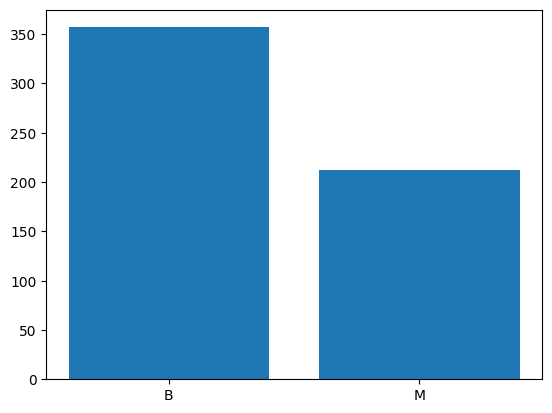

In [ ]:
x=targetCount.toPandas()["diagnosis"].values.tolist()
y=targetCount.toPandas()["count"].values.tolist()
plt.bar(x,y)
plt.show()



## Data Preparation<a class="anchor" id="data_preparation"></a>

In this step, I converted the diagnosis feature in my data to 0 and 1 since it is a categorical feature. Then I changed the feature name to label. I also converted the datatype of other properties to double.


In [ ]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: string (nullable = true)
 |-- texture_mean: string (nullable = true)
 |-- perimeter_mean: string (nullable = true)
 |-- area_mean: string (nullable = true)
 |-- smoothness_mean: string (nullable = true)
 |-- compactness_mean: string (nullable = true)
 |-- concavity_mean: string (nullable = true)
 |-- concave points_mean: string (nullable = true)
 |-- symmetry_mean: string (nullable = true)
 |-- fractal_dimension_mean: string (nullable = true)
 |-- radius_se: string (nullable = true)
 |-- texture_se: string (nullable = true)
 |-- perimeter_se: string (nullable = true)
 |-- area_se: string (nullable = true)
 |-- smoothness_se: string (nullable = true)
 |-- compactness_se: string (nullable = true)
 |-- concavity_se: string (nullable = true)
 |-- concave points_se: string (nullable = true)
 |-- symmetry_se: string (nullable = true)
 |-- fractal_dimension_se: string (nullable = true)
 |-- radiu

In [ ]:
indexer = StringIndexer(inputCol="diagnosis", outputCol="label") # OneHotEncoding 

In [ ]:
indexer_model = indexer.fit(df)
df= indexer_model.transform(df)

In [ ]:
df = df.drop(df.diagnosis)#drop diagnosis column

In [ ]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- radius_mean: string (nullable = true)
 |-- texture_mean: string (nullable = true)
 |-- perimeter_mean: string (nullable = true)
 |-- area_mean: string (nullable = true)
 |-- smoothness_mean: string (nullable = true)
 |-- compactness_mean: string (nullable = true)
 |-- concavity_mean: string (nullable = true)
 |-- concave points_mean: string (nullable = true)
 |-- symmetry_mean: string (nullable = true)
 |-- fractal_dimension_mean: string (nullable = true)
 |-- radius_se: string (nullable = true)
 |-- texture_se: string (nullable = true)
 |-- perimeter_se: string (nullable = true)
 |-- area_se: string (nullable = true)
 |-- smoothness_se: string (nullable = true)
 |-- compactness_se: string (nullable = true)
 |-- concavity_se: string (nullable = true)
 |-- concave points_se: string (nullable = true)
 |-- symmetry_se: string (nullable = true)
 |-- fractal_dimension_se: string (nullable = true)
 |-- radius_worst: string (nullable = true)
 |-- te

In [ ]:
for c in df.columns:# every feature convert to double except label
  if(c == 'label'):
    df=df.withColumn(c, col(c).cast('int'))
  else:
    df=df.withColumn(c, col(c).cast('double'))

In [ ]:
df.printSchema()

root
 |-- id: double (nullable = true)
 |-- radius_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- area_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- concave points_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)
 |-- radius_se: double (nullable = true)
 |-- texture_se: double (nullable = true)
 |-- perimeter_se: double (nullable = true)
 |-- area_se: double (nullable = true)
 |-- smoothness_se: double (nullable = true)
 |-- compactness_se: double (nullable = true)
 |-- concavity_se: double (nullable = true)
 |-- concave points_se: double (nullable = true)
 |-- symmetry_se: double (nullable = true)
 |-- fractal_dimension_se: double (nullable = true)
 |-- radius_worst: double (nullable = true)
 |-- te

NORMALIZED DATA

In this step, I normalized the data set using the min-max standardization.


I made feature selection before clustering in this section. I will explain the effects of these algorithms. I chose Random Forest for feature selection. This algorithm finds the importance of each feature. So with K-means, I can cluster my dataset according to these important features.

In [ ]:
df_normalize = df
# I use UDF because convert column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())


for i in df.columns:
  if(i == 'id'or i=='label'):
    continue
  # Convert column to vector type  
  assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")#  

  # MinMaxScaler Transformation
  scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

  # Create pipeline include vectorAssembler and MinMaxScaler 
  pipeline = Pipeline(stages=[assembler, scaler])

  # the pipeline is fitted on dataframe
  df_normalize = pipeline.fit(df_normalize).transform(df_normalize).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")
  df_normalize = df_normalize.drop(i)

In [ ]:
df_normalize.show()

+-----------+-----+------------------+-------------------+---------------------+----------------+----------------------+-----------------------+---------------------+--------------------------+--------------------+-----------------------------+----------------+-----------------+-------------------+--------------+--------------------+---------------------+-------------------+------------------------+------------------+---------------------------+-------------------+--------------------+----------------------+-----------------+-----------------------+------------------------+----------------------+---------------------------+---------------------+------------------------------+
|         id|label|radius_mean_Scaled|texture_mean_Scaled|perimeter_mean_Scaled|area_mean_Scaled|smoothness_mean_Scaled|compactness_mean_Scaled|concavity_mean_Scaled|concave points_mean_Scaled|symmetry_mean_Scaled|fractal_dimension_mean_Scaled|radius_se_Scaled|texture_se_Scaled|perimeter_se_Scaled|area_se_Scaled|s

RANDOM FOREST FEATURE SELECTION

In [ ]:
features = df.columns
df.printSchema()

root
 |-- id: double (nullable = true)
 |-- radius_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- area_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- concave points_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)
 |-- radius_se: double (nullable = true)
 |-- texture_se: double (nullable = true)
 |-- perimeter_se: double (nullable = true)
 |-- area_se: double (nullable = true)
 |-- smoothness_se: double (nullable = true)
 |-- compactness_se: double (nullable = true)
 |-- concavity_se: double (nullable = true)
 |-- concave points_se: double (nullable = true)
 |-- symmetry_se: double (nullable = true)
 |-- fractal_dimension_se: double (nullable = true)
 |-- radius_worst: double (nullable = true)
 |-- te

In [ ]:
vector = VectorAssembler(inputCols=features, outputCol="features")
RFM = RandomForestRegressor(labelCol="label", featuresCol="features") #create RFM model

stages = [vector, RFM]

pipe = Pipeline(stages=stages)

I optimize the parameters of my model using the code below.

In [ ]:
estimatorParam = ParamGridBuilder() \
.addGrid(RFM.maxDepth, [4, 6, 8]) \
.addGrid(RFM.maxBins, [5, 10, 20, 40]) \
.addGrid(RFM.impurity, ["variance"]) \
.build()

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

In [ ]:
crossval = CrossValidator(estimator=pipe,
                         estimatorParamMaps=estimatorParam,
                         evaluator=evaluator,
                         numFolds=3)

cvmodel = crossval.fit(df)

In [ ]:
featureSelection = pd.DataFrame(cvmodel.bestModel.stages[-1].featureImportances.toArray(), columns=["values"])
features_col = pd.Series(features)
featureSelection["features"] = features_col
importances = np.argsort(np.array(featureSelection['values']))[::-1][1:]

I showed the importance of the features for a model to be created for Random Forest.

In [ ]:
featureSelection

,values,features
0,0.003565,id
1,0.002926,radius_mean
2,0.007499,texture_mean
3,0.002316,perimeter_mean
4,0.000000,area_mean
5,0.000409,smoothness_mean
6,0.000804,compactness_mean
7,0.062100,concavity_mean
8,0.206838,concave points_mean
9,0.001253,symmetry_mean


I have shown the most important features as bar plots below. I will do clustering and classification using these features.

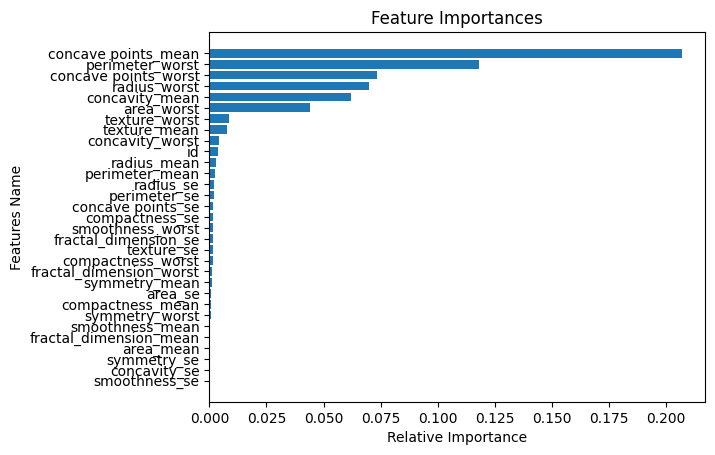

In [ ]:
importanceFeature = np.array(featureSelection['features'])[importances]
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data

performance = featureSelection["values"][importances]
y_pos = featureSelection["features"][importances]


ax.barh(y_pos, performance, align='center')

ax.invert_yaxis()  
ax.set_xlabel('Relative Importance')
ax.set_ylabel('Features Name')
ax.set_title('Feature Importances')

plt.show()


NORMALIZED AND RANDOM FOREST SELECTION

I re-apply feature selection using Random Forest with the normalized dataset.

In [ ]:
features_normalize = df_normalize.columns
df_normalize.printSchema()

root
 |-- id: double (nullable = true)
 |-- label: integer (nullable = true)
 |-- radius_mean_Scaled: double (nullable = true)
 |-- texture_mean_Scaled: double (nullable = true)
 |-- perimeter_mean_Scaled: double (nullable = true)
 |-- area_mean_Scaled: double (nullable = true)
 |-- smoothness_mean_Scaled: double (nullable = true)
 |-- compactness_mean_Scaled: double (nullable = true)
 |-- concavity_mean_Scaled: double (nullable = true)
 |-- concave points_mean_Scaled: double (nullable = true)
 |-- symmetry_mean_Scaled: double (nullable = true)
 |-- fractal_dimension_mean_Scaled: double (nullable = true)
 |-- radius_se_Scaled: double (nullable = true)
 |-- texture_se_Scaled: double (nullable = true)
 |-- perimeter_se_Scaled: double (nullable = true)
 |-- area_se_Scaled: double (nullable = true)
 |-- smoothness_se_Scaled: double (nullable = true)
 |-- compactness_se_Scaled: double (nullable = true)
 |-- concavity_se_Scaled: double (nullable = true)
 |-- concave points_se_Scaled: double 

In [ ]:
vector = VectorAssembler(inputCols=features_normalize, outputCol="features")
RFM = RandomForestRegressor(labelCol="label", featuresCol="features")

stages = [vector, RFM]

pipe = Pipeline(stages=stages)

estimatorParam = ParamGridBuilder() \
.addGrid(RFM.maxDepth, [4, 6, 8]) \
.addGrid(RFM.maxBins, [5, 10, 20, 40]) \
.addGrid(RFM.impurity, ["variance"]) \
.build()

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

crossval = CrossValidator(estimator=pipe,
                         estimatorParamMaps=estimatorParam,
                         evaluator=evaluator,
                         numFolds=3)

cvmodel = crossval.fit(df_normalize)

In [ ]:
featureSelectionNormalize = pd.DataFrame(cvmodel.bestModel.stages[-1].featureImportances.toArray(), columns=["values"])
features_col = pd.Series(features_normalize)
featureSelectionNormalize["features"] = features_col
importancesNormalized = np.argsort(np.array(featureSelectionNormalize['values']))[::-1][1:]

In [ ]:
featureSelectionNormalize

,values,features
0,0.004665,id
1,0.605343,label
2,0.000167,radius_mean_Scaled
3,0.003539,texture_mean_Scaled
4,0.031124,perimeter_mean_Scaled
5,0.000167,area_mean_Scaled
6,0.000000,smoothness_mean_Scaled
7,0.000000,compactness_mean_Scaled
8,0.008680,concavity_mean_Scaled
9,0.069341,concave points_mean_Scaled


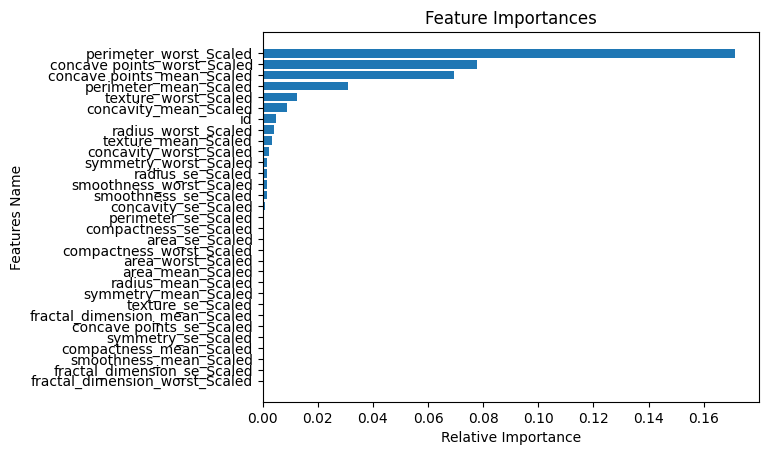

In [ ]:
importanceFeatureNormalize = np.array(featureSelectionNormalize['features'])[importancesNormalized]
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
# 
performance = featureSelectionNormalize["values"][importancesNormalized]
y_pos = featureSelectionNormalize["features"][importancesNormalized]


ax.barh(y_pos, performance, align='center')

ax.invert_yaxis()  
ax.set_xlabel('Relative Importance')
ax.set_ylabel('Features Name')
ax.set_title('Feature Importances')

plt.show()


As a result, when we apply the most important features with random forest for two datasets, we can see that the most important features are the same. Random Forest is a tree-based model and therefore does not require feature scaling. The role of scaling is often important in algorithms that require distance-based and Euclidean Distance.

## Modeling for Clustering <a class="anchor" id="clusteringmodel"></a>

I have determined the three most important features that I have determined with Random Forest. After that, according to these three features, I ran the K-means algorithm on the normalized and original dataset. Using K-means clustering, I clustered my data set by creating centers.

KMEANS

In [ ]:
vecAssembler = VectorAssembler(inputCols=importanceFeature[:3], outputCol="features")# create a vector whose name is 'features', which include all feature
df_kmeans = vecAssembler.transform(df).select('id', 'features')
df_kmeans.show()

+-----------+--------------------+
|         id|            features|
+-----------+--------------------+
|   842302.0|[0.1471,184.6,0.2...|
|   842517.0|[0.07017,158.8,0....|
|8.4300903E7|[0.1279,152.5,0.243]|
|8.4348301E7|[0.1052,98.87,0.2...|
|8.4358402E7|[0.1043,152.2,0.1...|
|   843786.0|[0.08089,103.4,0....|
|   844359.0|[0.074,153.2,0.1932]|
|8.4458202E7|[0.05985,110.6,0....|
|   844981.0|[0.09353,106.2,0....|
|8.4501001E7|[0.08543,97.65,0....|
|   845636.0|[0.03323,123.8,0....|
|8.4610002E7|[0.06606,136.5,0....|
|   846226.0|[0.1118,151.7,0.1...|
|   846381.0|[0.05364,112.0,0....|
|8.4667401E7|[0.08025,108.8,0....|
|8.4799002E7|[0.07364,124.1,0....|
|   848406.0|[0.05259,123.4,0....|
|8.4862001E7|[0.1028,136.8,0.2...|
|   849014.0|[0.09498,186.8,0....|
|  8510426.0|[0.04781,99.7,0.1...|
+-----------+--------------------+
only showing top 20 rows



In [ ]:
dfMostImportThreeFeature=importanceFeature[:3] #select most important three feature

I showed K means centers.

In [ ]:
kmeans = KMeans().setK(2).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[3.09699373e-02 9.00600723e+01 8.62251831e-02]
[9.72887662e-02 1.53614935e+02 1.91087597e-01]


In [ ]:
transformed = model.transform(df_kmeans).select('id', 'prediction')
rows = transformed.collect()

Using the id feature in my dataset, I combined my dataset with the value predicted by the K means algorithm.

In [ ]:
df_pred = spark.createDataFrame(rows)
df_pred.show()

+-----------+----------+
|         id|prediction|
+-----------+----------+
|   842302.0|         1|
|   842517.0|         1|
|8.4300903E7|         1|
|8.4348301E7|         0|
|8.4358402E7|         1|
|   843786.0|         0|
|   844359.0|         1|
|8.4458202E7|         0|
|   844981.0|         0|
|8.4501001E7|         0|
|   845636.0|         1|
|8.4610002E7|         1|
|   846226.0|         1|
|   846381.0|         0|
|8.4667401E7|         0|
|8.4799002E7|         1|
|   848406.0|         1|
|8.4862001E7|         1|
|   849014.0|         1|
|  8510426.0|         0|
+-----------+----------+
only showing top 20 rows



In [ ]:
df_pred = df_pred.join(df, 'id') #concatenate dataframes
df_pred.show()

+-----------+----------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+-----+
|         id|prediction|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|label|
+-----------+----------+----

I converted this dataset to pandas dataframe to facilitate the display of K-means results

In [ ]:
pddf_pred = df_pred.toPandas().set_index('id')

KMEANS NORMALIZED

I applied the above steps to normalized data.

In [ ]:
vecAssembler = VectorAssembler(inputCols=np.array(features_normalize)[importancesNormalized[:3]], outputCol="features")
df_kmeansNormalize = vecAssembler.transform(df_normalize).select('id', 'features')
df_kmeansNormalize.show()

+-----------+-------------------+
|         id|           features|
+-----------+-------------------+
|   842302.0|[0.668,0.912,0.731]|
|   842517.0| [0.54,0.639,0.349]|
|8.4300903E7|[0.508,0.835,0.636]|
|8.4348301E7|[0.241,0.885,0.523]|
|8.4358402E7|[0.507,0.558,0.518]|
|   843786.0|[0.264,0.598,0.402]|
|   844359.0|[0.512,0.664,0.368]|
|8.4458202E7|  [0.3,0.535,0.297]|
|   844981.0|[0.278,0.708,0.465]|
|8.4501001E7|[0.235,0.759,0.425]|
|   845636.0|[0.366,0.343,0.165]|
|8.4610002E7|[0.429,0.622,0.328]|
|   846226.0|[0.504,0.607,0.556]|
|   846381.0|[0.307,0.385,0.267]|
|8.4667401E7|[0.291,0.759,0.399]|
|8.4799002E7|[0.367,0.588,0.366]|
|   848406.0|[0.364,0.553,0.261]|
|8.4862001E7| [0.43,0.712,0.511]|
|   849014.0|[0.679,0.821,0.472]|
|  8510426.0|[0.245,0.443,0.238]|
+-----------+-------------------+
only showing top 20 rows



In [ ]:
dfNormalizeMostImportThreeFeature=np.array(features_normalize)[importancesNormalized[:3]]

In [ ]:
kmeansNormalize = KMeans().setK(2).setSeed(1).setFeaturesCol("features")
modelNormalize = kmeansNormalize.fit(df_kmeansNormalize)
centersNormalize = modelNormalize.clusterCenters()

print("Cluster Centers: ")
for center in centersNormalize:
    print(center)

Cluster Centers: 
[0.19120942 0.26190052 0.13158639]
[0.47090374 0.66334225 0.47096257]


In [ ]:
transformedNormalize = modelNormalize.transform(df_kmeansNormalize).select('id', 'prediction')
rowsNormalize = transformedNormalize.collect()

In [ ]:
df_predNormalize = spark.createDataFrame(rowsNormalize)
df_predNormalize.show()

+-----------+----------+
|         id|prediction|
+-----------+----------+
|   842302.0|         1|
|   842517.0|         1|
|8.4300903E7|         1|
|8.4348301E7|         1|
|8.4358402E7|         1|
|   843786.0|         1|
|   844359.0|         1|
|8.4458202E7|         1|
|   844981.0|         1|
|8.4501001E7|         1|
|   845636.0|         0|
|8.4610002E7|         1|
|   846226.0|         1|
|   846381.0|         0|
|8.4667401E7|         1|
|8.4799002E7|         1|
|   848406.0|         1|
|8.4862001E7|         1|
|   849014.0|         1|
|  8510426.0|         0|
+-----------+----------+
only showing top 20 rows



In [ ]:
df_predNormalize = df_predNormalize.join(df_normalize, 'id')
df_predNormalize.show()

+-----------+----------+-----+------------------+-------------------+---------------------+----------------+----------------------+-----------------------+---------------------+--------------------------+--------------------+-----------------------------+----------------+-----------------+-------------------+--------------+--------------------+---------------------+-------------------+------------------------+------------------+---------------------------+-------------------+--------------------+----------------------+-----------------+-----------------------+------------------------+----------------------+---------------------------+---------------------+------------------------------+
|         id|prediction|label|radius_mean_Scaled|texture_mean_Scaled|perimeter_mean_Scaled|area_mean_Scaled|smoothness_mean_Scaled|compactness_mean_Scaled|concavity_mean_Scaled|concave points_mean_Scaled|symmetry_mean_Scaled|fractal_dimension_mean_Scaled|radius_se_Scaled|texture_se_Scaled|perimeter_se_S

In [ ]:
pddf_predNormalize = df_predNormalize.toPandas().set_index('id')

## Clustering results<a class="anchor" id="clustering"></a>

I compared the clusters of the K means algorithm with the actual results. The results were close to each other, but when I applied this algorithm in the normalized dataset, the result was better.

The K-means algorithm works on variances. If the variances of the features differ among themselves, the algorithm tends to more variance features. Therefore, the result of the clustering of normalized data occurs closer to the real data graph.

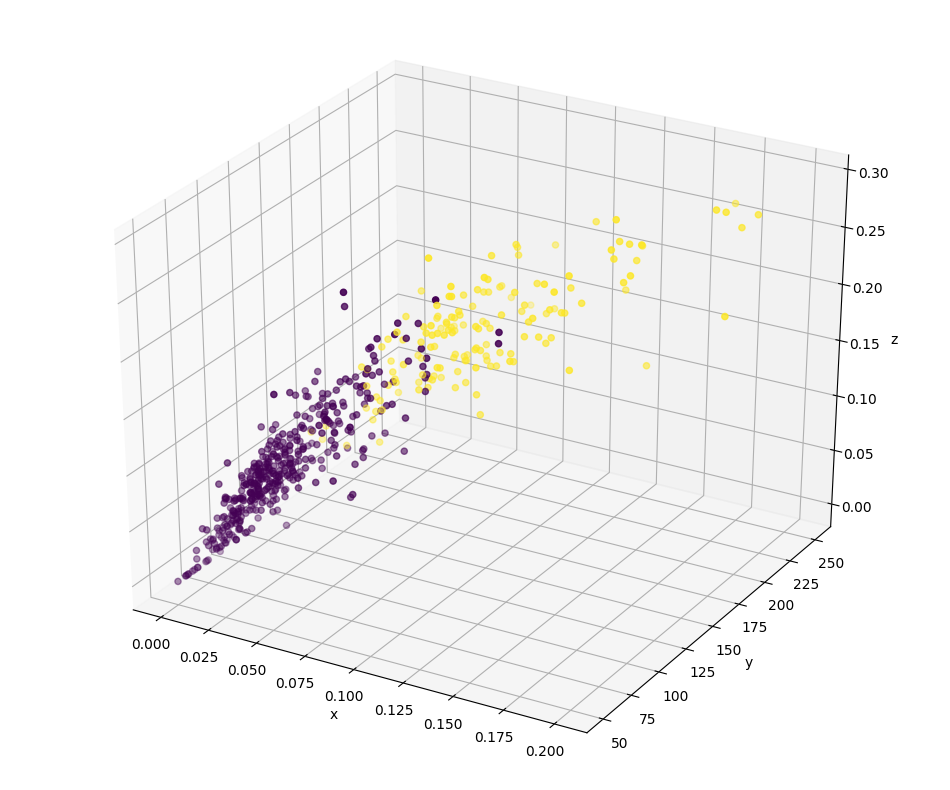

In [ ]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred[dfMostImportThreeFeature[0]],pddf_pred[dfMostImportThreeFeature[1]], pddf_pred[dfMostImportThreeFeature[2]], c=pddf_pred.prediction)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

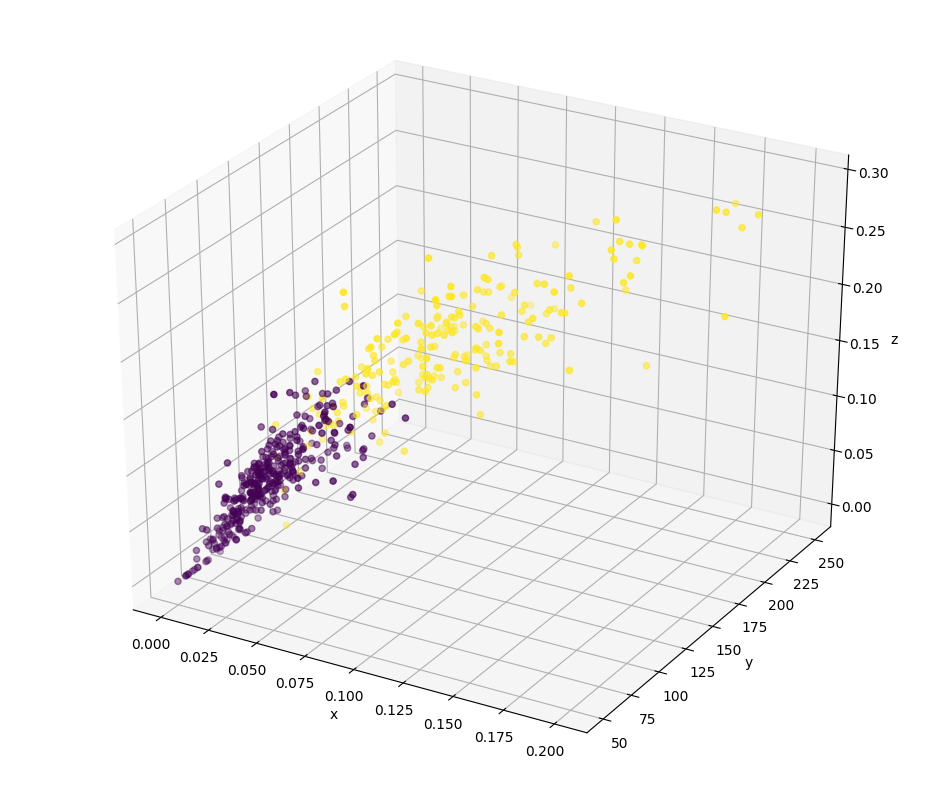

In [ ]:
dfPd = df.toPandas()
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter( dfPd[dfMostImportThreeFeature[0]],dfPd[dfMostImportThreeFeature[1]], dfPd[dfMostImportThreeFeature[2]], c=dfPd.label)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

Result of Clustering with Normalized Data

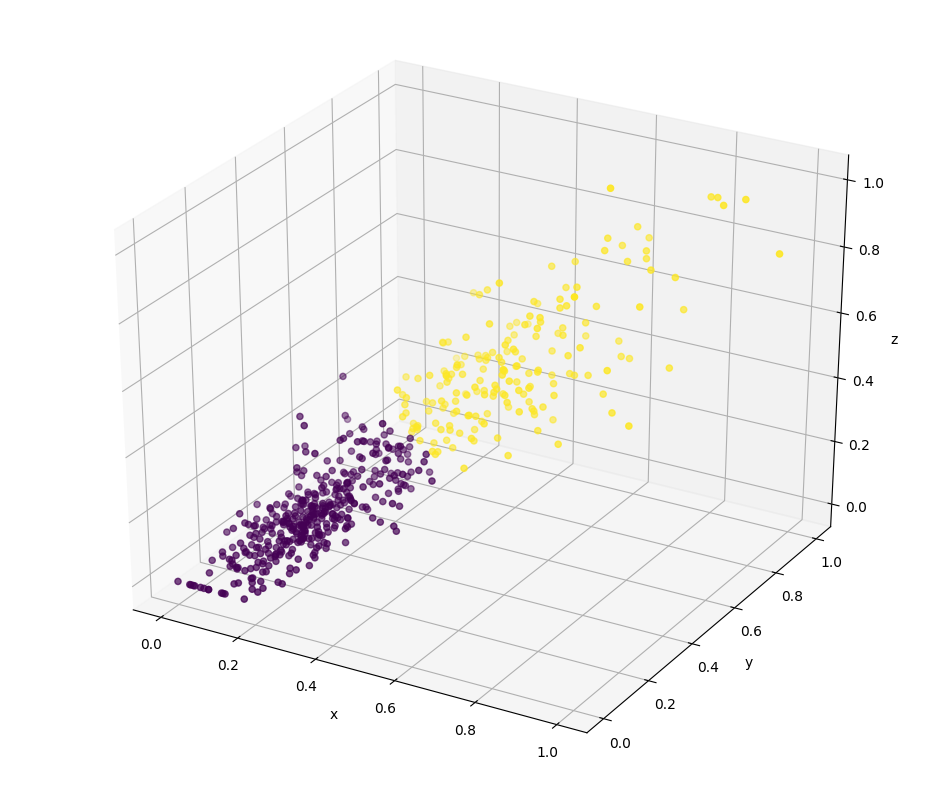

In [ ]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter( pddf_predNormalize[dfNormalizeMostImportThreeFeature[0]],pddf_predNormalize[dfNormalizeMostImportThreeFeature[1]], pddf_predNormalize[dfNormalizeMostImportThreeFeature[2]], c=pddf_predNormalize.prediction)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

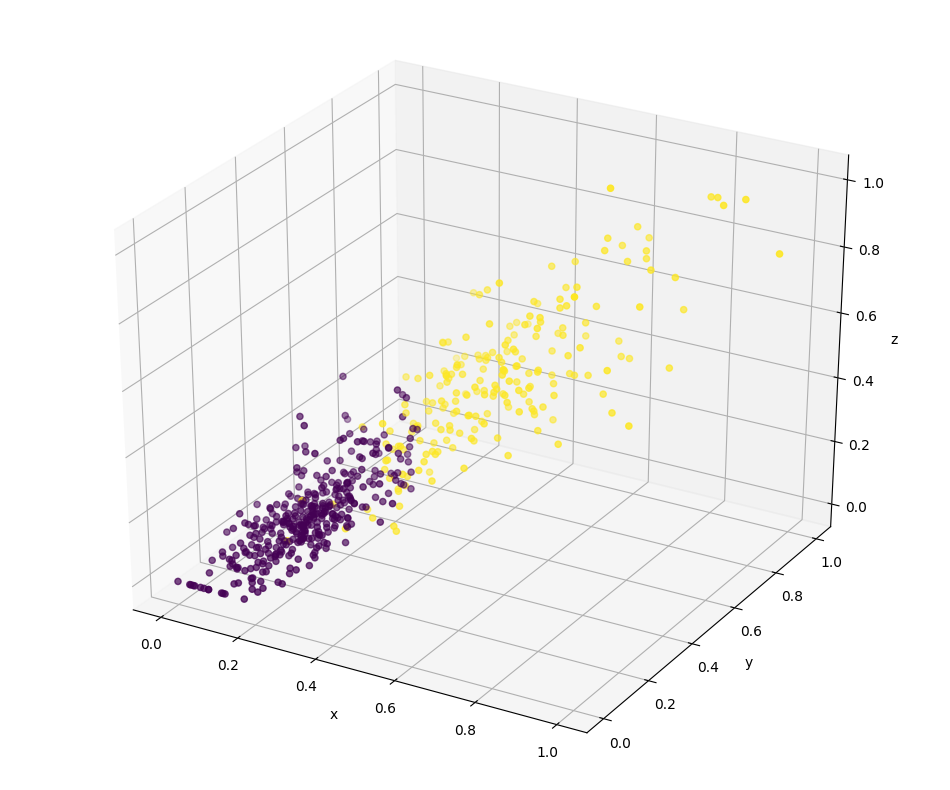

In [ ]:
dfPdNormalize = df_normalize.toPandas()
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(dfPdNormalize[dfNormalizeMostImportThreeFeature[0]],dfPdNormalize[dfNormalizeMostImportThreeFeature[1]], dfPdNormalize[dfNormalizeMostImportThreeFeature[2]], c=dfPdNormalize.label)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()


## Modeling for Classification <a class="anchor" id="classificationmodel"></a>

Classify Random Forest 

In this section, I chose the Random Forest algorithm. I used this algorithm because I used RF for selection feature, I wanted to use it for classification as well.

I created a vector that holds all the features except id and label. So I will train the model by giving this vector.

In [ ]:
assembler = VectorAssembler(inputCols=df.columns[1:-1], outputCol="features")
pipeline = Pipeline(stages = [assembler])
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['features']+features
df = df.select(selectedCols)
df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- id: double (nullable = true)
 |-- radius_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- area_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- concave points_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)
 |-- radius_se: double (nullable = true)
 |-- texture_se: double (nullable = true)
 |-- perimeter_se: double (nullable = true)
 |-- area_se: double (nullable = true)
 |-- smoothness_se: double (nullable = true)
 |-- compactness_se: double (nullable = true)
 |-- concavity_se: double (nullable = true)
 |-- concave points_se: double (nullable = true)
 |-- symmetry_se: double (nullable = true)
 |-- fractal_dimension_se: double (nullable = true)
 |-- radius

I divided the normalized and original data set into a test and train rate of 0.3. 

In [ ]:
train, test = df.randomSplit([0.7, 0.3], seed = 42)# split data
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 406
Test Dataset Count: 163


In [ ]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label') #create model
rfModel = rf.fit(train)#fit train data
predictions = rfModel.transform(test)# predict test data
predictions.select('prediction', 'probability').show(10)

+----------+--------------------+
|prediction|         probability|
+----------+--------------------+
|       0.0|[0.99519024660946...|
|       0.0|[0.99450928167616...|
|       0.0|[0.99450928167616...|
|       0.0|[0.94519465500304...|
|       0.0|[0.99450928167616...|
|       0.0|[0.94472295688984...|
|       0.0|[0.99450928167616...|
|       0.0|[0.99450928167616...|
|       0.0|[0.99450928167616...|
|       0.0|[0.94066312783001...|
+----------+--------------------+
only showing top 10 rows



Classify Random Forest Normalized Data

I applied the same operations to normalized data. So I could compare the results.

In [ ]:
assembler = VectorAssembler(inputCols=df_normalize.columns[2:], outputCol="features")
pipeline = Pipeline(stages = [assembler])
pipelineModel = pipeline.fit(df_normalize)
df_normalize = pipelineModel.transform(df_normalize)
selectedCols = ['features']+features_normalize
df_normalize = df_normalize.select(selectedCols)
df_normalize.printSchema()

root
 |-- features: vector (nullable = true)
 |-- id: double (nullable = true)
 |-- label: integer (nullable = true)
 |-- radius_mean_Scaled: double (nullable = true)
 |-- texture_mean_Scaled: double (nullable = true)
 |-- perimeter_mean_Scaled: double (nullable = true)
 |-- area_mean_Scaled: double (nullable = true)
 |-- smoothness_mean_Scaled: double (nullable = true)
 |-- compactness_mean_Scaled: double (nullable = true)
 |-- concavity_mean_Scaled: double (nullable = true)
 |-- concave points_mean_Scaled: double (nullable = true)
 |-- symmetry_mean_Scaled: double (nullable = true)
 |-- fractal_dimension_mean_Scaled: double (nullable = true)
 |-- radius_se_Scaled: double (nullable = true)
 |-- texture_se_Scaled: double (nullable = true)
 |-- perimeter_se_Scaled: double (nullable = true)
 |-- area_se_Scaled: double (nullable = true)
 |-- smoothness_se_Scaled: double (nullable = true)
 |-- compactness_se_Scaled: double (nullable = true)
 |-- concavity_se_Scaled: double (nullable = true

In [ ]:
trainNormalize, testNormalize = df_normalize.randomSplit([0.7, 0.3], seed = 42)
print("Training Dataset Count: " + str(trainNormalize.count()))
print("Test Dataset Count: " + str(testNormalize.count()))

Training Dataset Count: 406
Test Dataset Count: 163


In [ ]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(trainNormalize)
predictionsNormalize = rfModel.transform(testNormalize)
predictionsNormalize.select('prediction', 'probability').show(10)

+----------+--------------------+
|prediction|         probability|
+----------+--------------------+
|       0.0|[0.94194832822178...|
|       0.0|[0.99801770575444...|
|       0.0|[0.99801770575444...|
|       0.0|[0.99430352777555...|
|       0.0|[0.99801770575444...|
|       0.0|[0.99801770575444...|
|       0.0|[0.99801770575444...|
|       0.0|[0.99801770575444...|
|       0.0|[0.99801770575444...|
|       0.0|[0.99801770575444...|
+----------+--------------------+
only showing top 10 rows



I mentioned that I found the most important features using Random Forest. I classified the data using the 3 most important features of these features.

In [ ]:
df_normalize = df_normalize.drop(df_normalize.features)
assembler = VectorAssembler(inputCols=np.array(importanceFeatureNormalize)[:3], outputCol="features")
pipeline = Pipeline(stages = [assembler])
pipelineModel = pipeline.fit(df_normalize)
df_normalize = pipelineModel.transform(df_normalize)
selectedCols = ['features']+features_normalize
df_normalize = df_normalize.select(selectedCols)
df_normalize.printSchema()

root
 |-- features: vector (nullable = true)
 |-- id: double (nullable = true)
 |-- label: integer (nullable = true)
 |-- radius_mean_Scaled: double (nullable = true)
 |-- texture_mean_Scaled: double (nullable = true)
 |-- perimeter_mean_Scaled: double (nullable = true)
 |-- area_mean_Scaled: double (nullable = true)
 |-- smoothness_mean_Scaled: double (nullable = true)
 |-- compactness_mean_Scaled: double (nullable = true)
 |-- concavity_mean_Scaled: double (nullable = true)
 |-- concave points_mean_Scaled: double (nullable = true)
 |-- symmetry_mean_Scaled: double (nullable = true)
 |-- fractal_dimension_mean_Scaled: double (nullable = true)
 |-- radius_se_Scaled: double (nullable = true)
 |-- texture_se_Scaled: double (nullable = true)
 |-- perimeter_se_Scaled: double (nullable = true)
 |-- area_se_Scaled: double (nullable = true)
 |-- smoothness_se_Scaled: double (nullable = true)
 |-- compactness_se_Scaled: double (nullable = true)
 |-- concavity_se_Scaled: double (nullable = true

In [ ]:
trainNormalize, testNormalize = df_normalize.randomSplit([0.7, 0.3], seed = 42)
print("Training Dataset Count: " + str(trainNormalize.count()))
print("Test Dataset Count: " + str(testNormalize.count()))

Training Dataset Count: 406
Test Dataset Count: 163


In [ ]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(trainNormalize)
predictionsThreeFeature = rfModel.transform(testNormalize)
predictionsThreeFeature.select('prediction', 'probability').show(10)

+----------+--------------------+
|prediction|         probability|
+----------+--------------------+
|       0.0|[0.99387822396982...|
|       0.0|[0.99387822396982...|
|       0.0|[0.99387822396982...|
|       0.0|[0.99387822396982...|
|       0.0|[0.99387822396982...|
|       0.0|[0.99387822396982...|
|       0.0|[0.99387822396982...|
|       0.0|[0.99387822396982...|
|       0.0|[0.99387822396982...|
|       0.0|[0.99387822396982...|
+----------+--------------------+
only showing top 10 rows



I classified the data using the 5 most important features of these features.


In [ ]:
df_normalize = df_normalize.drop(df_normalize.features)
assembler = VectorAssembler(inputCols=np.array(importanceFeatureNormalize)[:5], outputCol="features")
pipeline = Pipeline(stages = [assembler])
pipelineModel = pipeline.fit(df_normalize)
df_normalize = pipelineModel.transform(df_normalize)
selectedCols = ['features']+features_normalize
df_normalize = df_normalize.select(selectedCols)
df_normalize.printSchema()

root
 |-- features: vector (nullable = true)
 |-- id: double (nullable = true)
 |-- label: integer (nullable = true)
 |-- radius_mean_Scaled: double (nullable = true)
 |-- texture_mean_Scaled: double (nullable = true)
 |-- perimeter_mean_Scaled: double (nullable = true)
 |-- area_mean_Scaled: double (nullable = true)
 |-- smoothness_mean_Scaled: double (nullable = true)
 |-- compactness_mean_Scaled: double (nullable = true)
 |-- concavity_mean_Scaled: double (nullable = true)
 |-- concave points_mean_Scaled: double (nullable = true)
 |-- symmetry_mean_Scaled: double (nullable = true)
 |-- fractal_dimension_mean_Scaled: double (nullable = true)
 |-- radius_se_Scaled: double (nullable = true)
 |-- texture_se_Scaled: double (nullable = true)
 |-- perimeter_se_Scaled: double (nullable = true)
 |-- area_se_Scaled: double (nullable = true)
 |-- smoothness_se_Scaled: double (nullable = true)
 |-- compactness_se_Scaled: double (nullable = true)
 |-- concavity_se_Scaled: double (nullable = true

In [ ]:
trainNormalize, testNormalize = df_normalize.randomSplit([0.7, 0.3], seed = 42)
print("Training Dataset Count: " + str(trainNormalize.count()))
print("Test Dataset Count: " + str(testNormalize.count()))

Training Dataset Count: 406
Test Dataset Count: 163


In [ ]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(trainNormalize)
predictionsFiveFeatures = rfModel.transform(testNormalize)
predictionsFiveFeatures.select('prediction', 'probability').show(10)

+----------+--------------------+
|prediction|         probability|
+----------+--------------------+
|       0.0|[0.98605779136369...|
|       0.0|[0.99039613065841...|
|       0.0|[0.98748636279226...|
|       0.0|[0.99039613065841...|
|       0.0|[0.99039613065841...|
|       0.0|[0.99039613065841...|
|       0.0|[0.99039613065841...|
|       0.0|[0.99039613065841...|
|       0.0|[0.99039613065841...|
|       0.0|[0.99039613065841...|
+----------+--------------------+
only showing top 10 rows



## Evaluation<a class="anchor" id="evaluation"></a>

In this section, I will show the accuracy values ​​and confusion matrix of the 4 models I created above.

In [ ]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        99
           1       0.94      0.97      0.95        64

    accuracy                           0.96       163
   macro avg       0.96      0.96      0.96       163
weighted avg       0.96      0.96      0.96       163



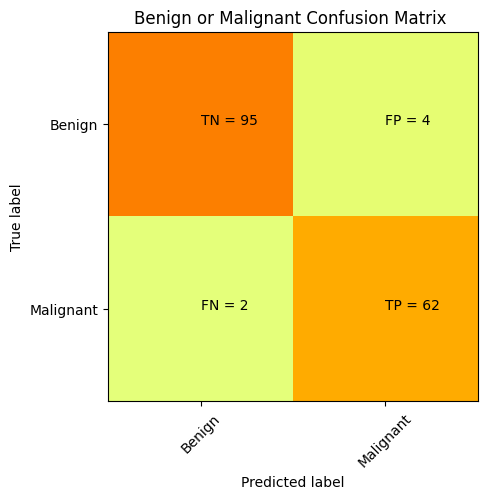

Accuracy on test set : 96.31901840490798


In [ ]:
showConfusionMatrix(y_true,y_pred)

In [ ]:
y_true = predictionsNormalize.select(['label']).collect()
y_pred = predictionsNormalize.select(['prediction']).collect()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        99
           1       1.00      0.94      0.97        64

    accuracy                           0.98       163
   macro avg       0.98      0.97      0.97       163
weighted avg       0.98      0.98      0.98       163



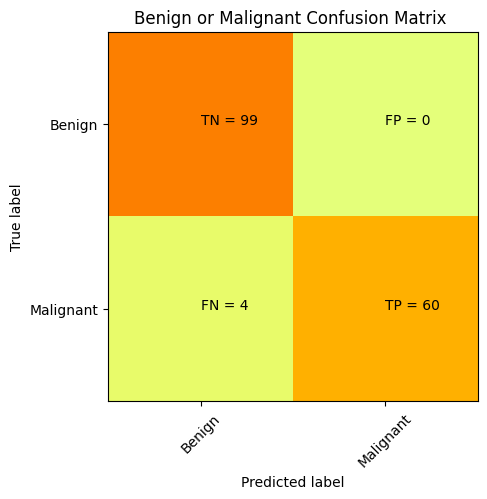

Accuracy on test set : 97.54601226993866


In [ ]:
showConfusionMatrix(y_true,y_pred)

As can be understood from the matrix above, when we normalize the data, the accuracy value increases. The reason for this is that when the dataset is normalized, it becomes more stable and each feature has the same variance, so a feature which has the high variance does not affect the RF algorithm more than others.

In [ ]:
y_true = predictionsThreeFeature.select(['label']).collect()
y_pred = predictionsThreeFeature.select(['prediction']).collect()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95        98
           1       0.91      0.95      0.93        65

    accuracy                           0.94       163
   macro avg       0.94      0.95      0.94       163
weighted avg       0.95      0.94      0.94       163



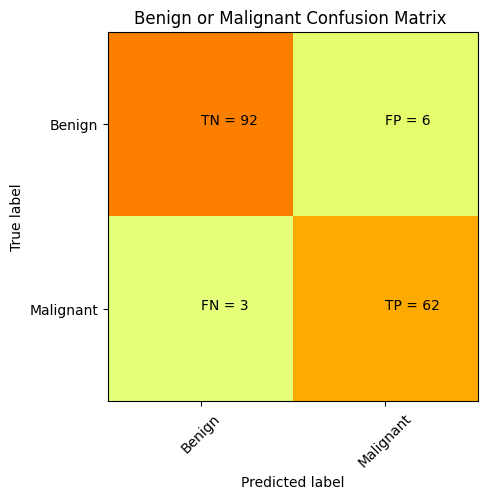

Accuracy on test set : 94.47852760736197


In [ ]:
showConfusionMatrix(y_true,y_pred)

In [ ]:
y_true = predictionsFiveFeatures.select(['label']).collect()
y_pred = predictionsFiveFeatures.select(['prediction']).collect()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        98
           1       0.95      0.97      0.96        65

    accuracy                           0.97       163
   macro avg       0.97      0.97      0.97       163
weighted avg       0.97      0.97      0.97       163



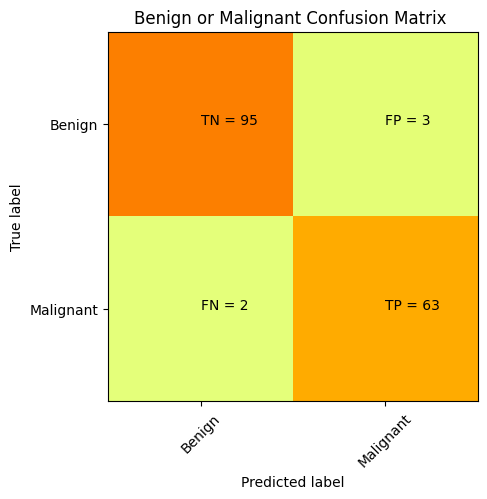

Accuracy on test set : 96.93251533742331


In [ ]:
showConfusionMatrix(y_true,y_pred)

I wanted to use the most important features I found using Random Forest. I created models using three and five of the most important features of normalized data. When I look at the results of these models, the accuracy value is 94% when I use the three most important features, and 96% when I use the five most important features. Also, when I try to classify normalized data using all features, the accuracy value is 97%. When I classify non-normalized data using all the features, the accuracy value is 96%.

As a result, higher accuracy values ​​can be achieved by increasing the number of most important features used.

Finally, I examined which of the features would be more advantageous to use for classification and clustering.

However, between 'area_se' and 'symmetry_worst' is not appearing as a linear graph. It may be advantageous to use these two properties for classification and clustering algorithms. Because, as seen in the figure, it is easier to distinguish than linear graphics. 

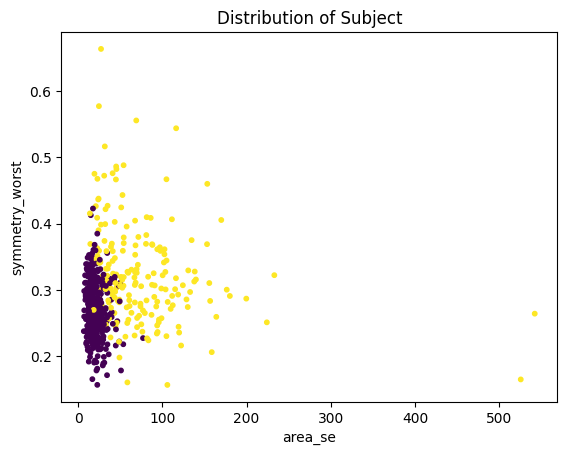

In [ ]:
plt.scatter(dfPd.iloc[:,14].values,dfPd.iloc[:,29].values, s=10, c=dfPd.label)
plt.title('Distribution of Subject')
plt.xlabel('area_se')
plt.ylabel('symmetry_worst')
plt.show()

between 'radius_mean' and 'perimeter_mean' the graph is forming linearly. Also, if we examine the graphic carefully, it is seen that categorical data are intertwined. Therefore, it is meaningless to use these two data simultaneously for classification and clustering. 


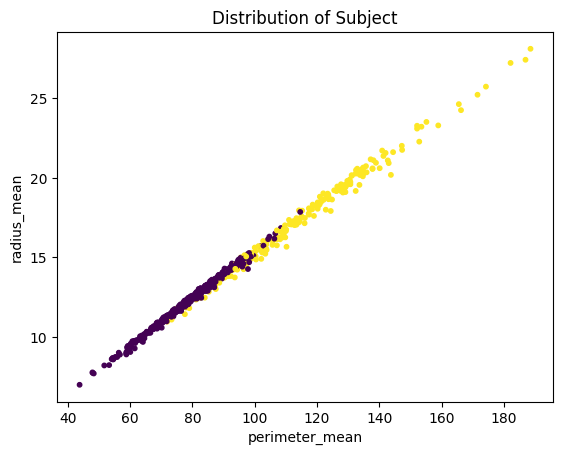

In [ ]:
plt.scatter(dfPd.iloc[:,3].values,dfPd.iloc[:,1].values, s=10, c=dfPd.label)
plt.title('Distribution of Subject')
plt.xlabel('perimeter_mean')
plt.ylabel('radius_mean')
plt.show()